## Stochastic volatility using SMC

In this notebook we implement a particle filter to estimate the stochastic volatility of a series of observations, which in this case are, the log returns of a financial asset.

### Preliminaries

The Heston model is a stochastic volatility model encountered in finance. According to this model, the price of the asset is driven by the below sde:

$dS_t = \mu_r S_t dt + \sqrt{\nu_t} S_t dW1_t$

$d\nu_t = \kappa (\mu_v - \nu_t) dt + \eta \sqrt{\nu_t} dW2_t$

In the above set of equations $dW1_t$ and  $dW2_t$ are two Brownian motions with correlation $\rho$. $\mu_r$ is the growth rate of the asset. $\nu_t$ is the stochastic volatility of the asset which has a long term average $\mu_v$ and mean reverts at a rate $\kappa$. The term $\eta$ is the volatility of volatility. 

The model parameters are $\mu_r, \mu_v, \nu_t, \eta, \kappa$. In this discussion we assume that these are given. The estimation of these parameters is a topic for another notebook.

### Discretization

We discretize the above equation using the Euler scheme described in the notebook on simulating the Heston model. Note that we transform the asset price $S_t$ to $ln(S_t)$ in which case the sde transforms to:

$d ln(S_t) = (\mu_r - 0.5 \nu_t) dt + \sqrt{\nu_t} dW1_t$

$ln(S_{t+dt} = ln(S_t) + (r - 0.5 \nu_t) dt + \sqrt{\nu_t dt} N1_t $

The corresponding discretization for the stochastic volatility becomes:

$\nu_{t+dt} = \nu_t + \kappa (\mu_v - 0.5 \nu_t) dt + \sqrt{\nu_t dt} N2_t $

$N1_t$ and $N2_t$ are two standard normal variables with correlation $\rho$

### Particle filtering

We will not discuss the filtering problem in detail in what follows but only give a brief outline of the approach. An excellent introduction to recursive bayesian filtering can be found [here.](https://people.csail.mit.edu/mrub/talks/filtering.pdf)

We are trying to estimate $p(\nu_k|S_{0:k})$. This can be expressed recursively as 

$\dfrac{p(\nu_k|\nu_{k-1}) p(S_k|\nu_k)}{p(S_k|S_{0:k-1})}$  $p(\nu_{k-1}|S_{0:k-1})$

where $p()$ represents a probability distribution. However $p(\nu_k|S_k)$ is not tractable and we resort to importance sampling from $p(\nu_k|\nu_{k-1})$ in order to simpllify the problem. We will not describe the importance sampling here. An excellent reference on particle filtering and smoothing is [Doucet and Johanssen](https://www.stats.ox.ac.uk/~doucet/doucet_johansen_tutorialPF2011.pdf). It suffices to say that with the above choice of the proposal function the particle filter is called the bootstrap particle filter using resampling. 

### Bootstrap particle filter implementation in Python

As usual we start with imports


In [24]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
plt.rcParams["figure.figsize"] = (17,7)

Next we define the model parameters and inputs which we assume are known.

In [25]:
'''
Define simulation parameters
All rates are annualized.
'''
np.random.seed(20)
theta = mu_r,kappa,mu_v,eta,rho=0.05,10,0.26,0.3,-0.8
T = 2# final time in years
s0 = 120
x0 = np.log(s0)
v0 = mu_v 

In [26]:
def hestonSimulation(x0,v0,T,N,theta):
        
    '''
    s0,v0:initial log spot and vol
    T    : final time in years    
    N    : number of samples in [0,T]
    theta: parameter vector     
    '''
    mu_r,kappa,mu_v,eta,rho = theta
    dt = float(T)/N
    sqrtdt=dt**0.5
    
    logSpot=np.zeros((N,))
    vol=np.zeros_like(logSpot)    
    logSpot[0]=x0
    vol[0]=v0
    
    cov=np.ones((2,2))
    cov[0,1]=rho
    cov[1,0]=rho
    #generate correlated random variables
    mvr = np.random.multivariate_normal([0,0],cov,size=N//2)
    #use antithetic variates, only applies if rho is negative
    mvr = np.concatenate((mvr, -mvr),axis=0)   
    
    for t in np.arange(0,N):
            prevLogSpot=logSpot[t-1]
            prevVol=vol[t-1]
            
            if t>0:
                vol[t] = prevVol + kappa*(mu_v - prevVol) *dt + eta * (prevVol)**0.5*sqrtdt*mvr[t-1,1]
                #full truncation scheme
                vol[t] =  max(1e-4,vol[t])
                logSpot[t] = prevLogSpot +  (mu_r - 0.5*prevVol) *dt + (prevVol)**0.5*sqrtdt*mvr[t-1,0]

    return(logSpot,vol)

The above function defined above will be used to mock up some data as below. Note that we use the full truncation scheme to ensure that the volatility is always positive.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f3f5543c128>,
      dtype=object)

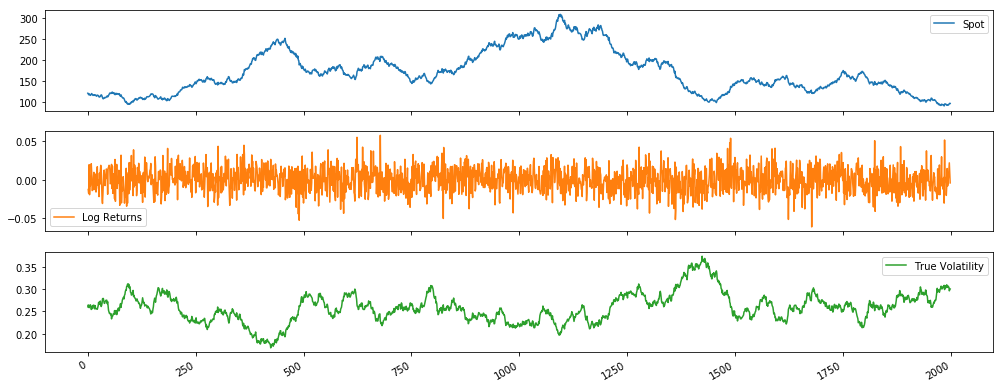

In [27]:
np.random.seed(20)
tol=1e-5
N=2000#generate 2000 points in [0,T]
logSpot,vol=hestonSimulation(x0,v0,T,N,theta)
tmp=pd.DataFrame()
tmp['Spot'] = np.exp(logSpot)
tmp['logS'] = logSpot
tmp['Log Returns'] = tmp['logS'].diff()
tmp['True Volatility'] = vol
tmp[['Spot','Log Returns','True Volatility']].plot(subplots=True)

Next we define the components of the bootstrap particle filter

In [28]:
def propagate(xk,theta,dt,rvs):
    mu_r,kappa,mu_v,eta,rho=theta
    drift = kappa *(mu_v-xk) *dt
    diff = eta * (xk*dt)**0.5 * rvs
    particles= np.maximum(1e-4,xk+drift+diff)
    return(particles)

def pYGivenX(obs,particles,theta,dt):
    mu_r,kappa,mu_v,eta,rho=theta
    drift = (mu_r-0.5*particles)*dt
    diff = (particles*dt)**0.5
    assert(diff>0.).all()
    probs = norm.pdf(obs,drift,diff)
    return(probs)

def resample(particles,weights,M):
    draw = np.random.multinomial(weights.shape[0],weights[:,0])
    particles = np.repeat(particles,draw).reshape(weights.shape[0],1)
    return(particles)
    

In the below we implement the OAPF or the optimal auxilliary particle filter. For more details please refer [this paper](http://hedibert.org/wp-content/uploads/2013/12/lopes-tsay-2011.pdf)

N=2000.00 M=100.00 rmse =0.03443


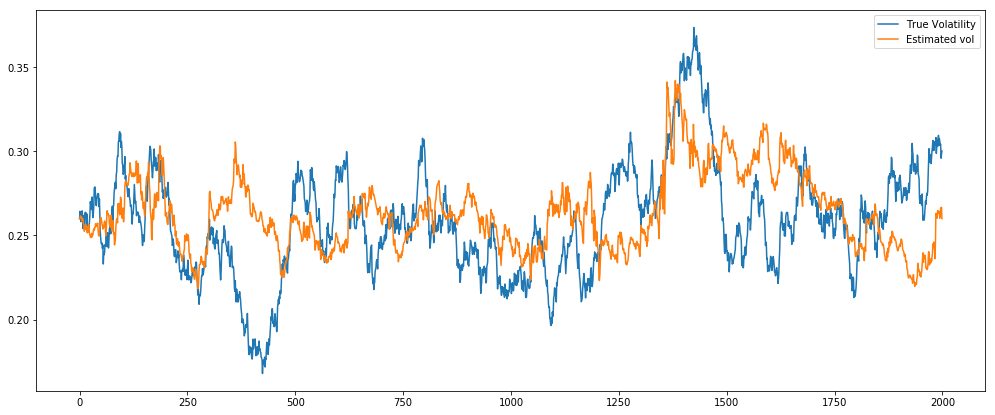

In [29]:
M=100#number of particles
S=1#optional number of simulations to average over
dt = float(T)/N
obs=tmp['Log Returns'].values
particles=np.ones((N,M,1))
x0=[mu_v]
vol_est = np.zeros((N,S,1))

for s in range(S):
    rvs =  np.random.normal(size=(N,M,1))
    particles = np.ones((N,M,1))*x0
    weights =np.ones((N,M,1))*1./M
    equalweights = weights[0].copy()
    for t in range(N-1):
        if t>0:
            #compute weights
            weights[t] = pYGivenX(obs[t],particles[t-1],theta,dt)
            
            #normalize
            weights[t]= weights[t]/np.sum(weights[t])
            assert(np.sum(weights[t]) - 1 < 1e-8)
            
            #resample particle t-1 to using weights[t]
            particles[t-1]=resample(particles[t-1],weights[t],M)
            
            #propagate particles
            particles[t]=propagate(particles[t-1],theta,dt,rvs[t])
        
    #mean as all particles are equally weighted after resampling
    vol_est[:,s] = np.mean(particles,axis=1)
    

tmp['Estimated vol']=vol_est.mean(1)
tmp[['True Volatility','Estimated vol']].plot()
rmse = ((tmp['Estimated vol']-tmp['True Volatility'])**2).mean()**0.5
print('N={:02.2f} M={:02.2f} rmse ={:02.5f}'.format(N,M,rmse,))